In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [3]:
dataset_settings

,network_model,stain,margins,num_sample_per_class,stacks,cell_features_used
dataset_id,,,,,,
20,Inception-BN,nissl,200/500,1000,MD585,NaN
21,Inception-BN,nissl,200/500,1000,MD589,NaN
22,Inception-BN,nissl,200/500,1000,MD594,NaN
23,inception-bn-blue,nissl,500,1000,MD585,NaN
24,inception-bn-blue,nissl,500,1000,MD589,NaN
25,inception-bn-blue,nissl,500,1000,MD594,NaN
50,inception-bn-blue,neurotrace_blue,500,1000,MD642,NaN
90,NaN,nissl,500,1000,MD589,allSizeHist/huMomentsHist
92,NaN,nissl,500,1000,MD589,largeLargeLinkLenHist


In [4]:
dataset_id = 50
dataset_properties = dataset_settings.loc[dataset_id]

num_samples_per_label = dataset_properties['num_sample_per_class']
stacks = dataset_properties['stacks'].split('/')
network_model = dataset_properties['network_model']
stain = dataset_properties['stain']

In [5]:
structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = map(int, str(dataset_properties['margins']).split('/'))
margins_to_sample = [500]

surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]

surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

labels_to_sample = structures_to_sample + \
surround_positive_labels_to_sample + surround_noclass_labels_to_sample

# Gather Features for alternate stacks

In [6]:
grid_indices_lookup_fps = {'MD642': \
    DataManager.get_annotation_to_grid_indices_lookup_filepath(stack='MD642', by_human=False,
                                                               stack_m='atlasV3', 
                                                               classifier_setting_m=37, 
                                                               classifier_setting_f=37, 
                                                               warp_setting=1, 
                                                               trial_idx=4)}

In [10]:
features, addresses = generate_dataset(num_samples_per_label=10, 
                 stacks=stacks,
                 labels_to_sample=labels_to_sample,
                 model_name=network_model,
                grid_indices_lookup_fps=grid_indices_lookup_fps)

Read grid indices lookup: 3.18 seconds
Sample addresses (stack MD642): 0.74 seconds.
Sample addresses: 3.96 seconds
Map addresses to features: 173.56 seconds


In [14]:
patches = extract_patches_given_locations_multiple_sections(addresses=addresses['Pn'], 
                                                            location_or_grid_index='grid_index', 
                                                            version='cropped_gray')

Load image: 2.90 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif


Child returned 0
2.16 seconds.
Load image: 2.49 seconds.
Load image: 2.80 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif


Child returned 0
2.10 seconds.
Load image: 2.43 seconds.
Load image: 2.79 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif


Child returned 0
2.00 seconds.
Load image: 2.33 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif


Child returned 0
1.92 seconds.
Load image: 2.25 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif


Child returned 0
2.09 seconds.
Load image: 2.42 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif


Child returned 0
1.97 seconds.
Load image: 2.30 seconds.
Load image: 3.33 seconds.


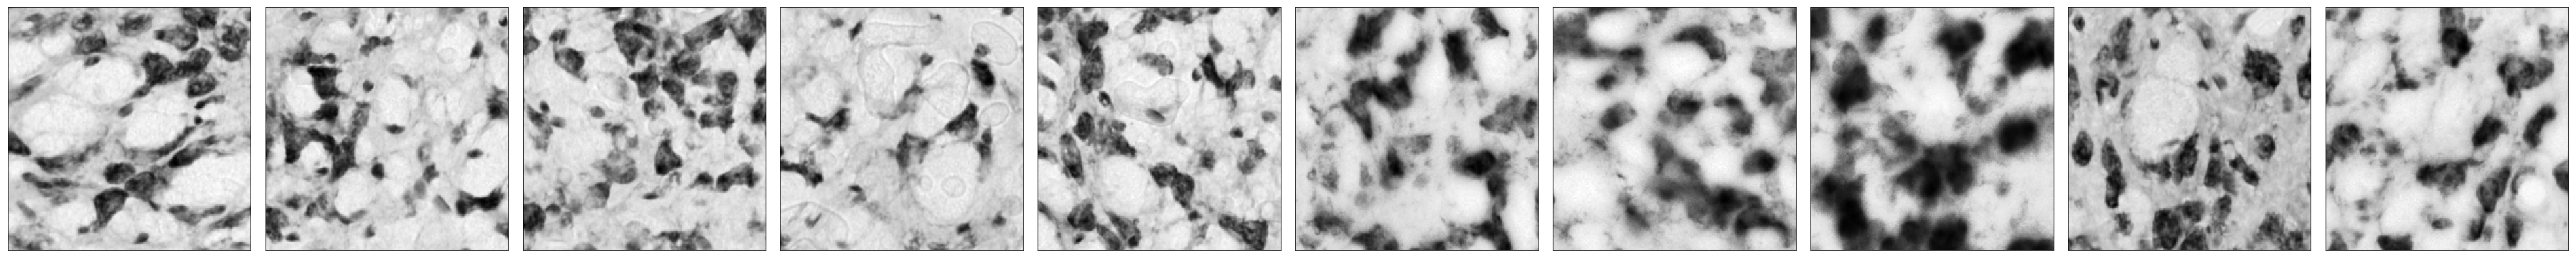

In [15]:
display_images_in_grids(patches, nc=10, cmap=plt.cm.gray)

In [56]:
patch_locations = grid_parameters_to_sample_locations(get_default_gridspec(stack='MD642'))[[gi for _,_,gi in addresses['Pn']]]

In [58]:
viz = patch_boxes_overlay_on(bg='original', 
                             downscale_factor=8, 
                            locs=patch_locations, 
                            patch_size=224,
                      stack='MD642', sec=201,
                        img_version='cropped_gray')
display_image(viz)

rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray.tif


Child returned 0
Child returned 0
1.98 seconds.


/shared/MouseBrainAtlas/learning/tmp.jpg

# gather features for nissl stacks

In [19]:
features, addresses = generate_dataset(num_samples_per_label=num_samples_per_label, 
                                                     stacks=stacks,
                                                     labels_to_sample=labels_to_sample,
                                                    model_name=network_model)

rm -rf /shared/CSHL_labelings_v3/MD594/MD594_annotation_grid_indices.h5 && mkdir -p /shared/CSHL_labelings_v3/MD594
aws s3 cp s3://mousebrainatlas-data/CSHL_labelings_v3/MD594/MD594_annotation_grid_indices.h5 /shared/CSHL_labelings_v3/MD594/MD594_annotation_grid_indices.h5


Child returned 0
Child returned 0
5.48 seconds.
Read: 28.35 seconds
Cell is empty.
Cell is empty.
Cell is empty.
Sample addresses (stack MD594): 0. seconds.
Sample addresses: 29.26 seconds


('MD594', 94)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 111)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_featu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 128)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 146)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_f

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.62 seconds.
Child returned 0
0.63 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.65 seconds.
Patch in annotation but not in mask: MD594 111 MD594-N20-2015.08.26-21.59.11_MD594_1_0058 @35615
Patch in annotation but not in mask: MD594 111 MD594-N20-2015.08.26-21.59.11_MD594_1_0058 @35421
Child returned 0
0.63 seconds.
Patch in annotation but not in mask: MD594 146 MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083 @44363
Patch in annotation but not in mask: MD594 146 MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083 @45340
Patch in annotation but not in mask: MD594 146 MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083 @48118
Child returned 0
0.87 seconds.


('MD594', 95)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.55 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.98 seconds.


('MD594', 147)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.95 seconds.
Child returned 0
0.87 seconds.


('MD594', 129)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 96)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_01

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/in

Child returned 0
0.66 seconds.
Child returned 0
0.94 seconds.


('MD594', 112)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.62 seconds.
Child returned 0
0.65 seconds.
Patch in annotation but not in mask: MD594 147 MD594-N29-2015.08.26-22.29.38_MD594_1_0085 @43974


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Child returned 0
0.88 seconds.
Child returned 0
0.95 seconds.


('MD594', 148)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 97)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_01

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.54 seconds.
Child returned 0
0.62 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.93 seconds.


('MD594', 130)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0
0.88 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 113)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.99 seconds.


('MD594', 98)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.63 seconds.
Child returned 0
0.62 seconds.
Child returned 0
0.91 seconds.
Child returned 0
0.63 seconds.
Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 @35607


('MD594', 149)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 @35421
Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 @34845
Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 @34844
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 @35618


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.54 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.83 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 99)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 @35219
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Child returned 0
0.92 seconds.
Patch in annotation but not in mask: MD594 99 MD594-N17-2015.08.26-21.48.26_MD594_2_0050 @24103


('MD594', 132)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.89 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 150)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.94 seconds.


('MD594', 114)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.66 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.64 seconds.
Child returned 0
0.83 seconds.


('MD594', 100)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 114 MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059 @34845
Patch in annotation but not in mask: MD594 150 MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086 @43975
Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 100 MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050 @32877
Patch in annotation but not in mask: MD594 100 MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050 @30360
Patch in annotation but not in mask: MD594 100 MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050 @25285
Patch in annotation but not in mask: MD594 100 MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050 @23719


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 132 MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073 @42846


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 132 MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073 @43236
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.83 seconds.
Child returned 0
0.96 seconds.


('MD594', 101)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 151)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cr

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Child returned 0
0.60 seconds.
Child returned 0
0.90 seconds.


('MD594', 133)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 101 MD594-N17-2015.08.26-21.48.26_MD594_3_0051 @32882
Patch in annotation but not in mask: MD594 101 MD594-N17-2015.08.26-21.48.26_MD594_3_0051 @33076
Patch in annotation but not in mask: MD594 101 MD594-N17-2015.08.26-21.48.26_MD594_3_0051 @32490
Patch in annotation but not in mask: MD594 101 MD594-N17-2015.08.26-21.48.26_MD594_3_0051 @25674
Patch in annotation but not in mask: MD594 101 MD594-N17-2015.08.26-21.48.26_MD594_3_0051 @31714
Patch in annotation but not in mask: MD594 101 MD594-N17-2015.08.26-21.48.26_MD594_3_0051 @22941
Patch in annotation but not in mask: MD594 101 MD594-N17-2015.08.26-21.48.26_MD594_3_0051 @22740
Child returned 0
0.86 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 115)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 151 MD594-N30-2015.08.26-22.33.07_MD594_1_0088 @46706
Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/

Child returned 0
0.65 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Child returned 0
0.84 seconds.
Patch in annotation but not in mask: MD594 115 MD594-N21-2015.08.26-22.02.28_MD594_1_0061 @35038


('MD594', 102)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.89 seconds.


('MD594', 152)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.63 seconds.
Patch in annotation but not in mask: MD594 133 MD594-N25-2015.08.26-22.16.07_MD594_2_0074 @42998
Patch in annotation but not in mask: MD594 133 MD594-N25-2015.08.26-22.16.07_MD594_2_0074 @42847
Patch in annotation but not in mask: MD594 102 MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051 @32494
Patch in annotation but not in mask: MD594 102 MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051 @25286
Patch in annotation but not in mask: MD594 102 MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051 @32298
Patch in annotation but not in mask: MD594 102 MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051 @32688


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.55 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.84 seconds.


('MD594', 103)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.91 seconds.


('MD594', 116)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.94 seconds.
Child returned 0
0.76 seconds.


('MD594', 134)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 103 MD594-N18-2015.08.26-21.52.46_MD594_1_0052 @32298
Patch in annotation but not in mask: MD594 103 MD594-N18-2015.08.26-21.52.46_MD594_1_0052 @24310


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.09 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.66 seconds.


('MD594', 153)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.67 seconds.
Child returned 0
0.64 seconds.
Child returned 0
0.89 seconds.


('MD594', 104)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 134 MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074 @43432
Patch in annotation but not in mask: MD594 134 MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074 @42458
Patch in annotation but not in mask: MD594 134 MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074 @42651
Patch in annotation but not in mask: MD594 134 MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074 @43584


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 134 MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074 @35639
Patch in annotation but not in mask: MD594 134 MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074 @35055
Child returned 0
0.98 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.06 seconds.


('MD594', 117)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


('MD594', 154)
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/

Child returned 0
0.98 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 105)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_featu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.63 seconds.
Child returned 0
0.62 seconds.
Child returned 0
0.90 seconds.


('MD594', 135)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 117 MD594-N21-2015.08.26-22.02.28_MD594_2_0062 @35041
Child returned 0
1.13 seconds.
Patch in annotation but not in mask: MD594 105 MD594-N18-2015.08.26-21.52.46_MD594_2_0053 @34435
Child returned 0
Patch in annotation but not in mask: MD594 105 MD594-N18-2015.08.26-21.52.46_MD594_2_0053 @33854
0.61 seconds.
Patch in annotation but not in mask: MD594 154 MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090 @32537


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 105 MD594-N18-2015.08.26-21.52.46_MD594_2_0053 @23141
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 105 MD594-N18-2015.08.26-21.52.46_MD594_2_0053 @33659


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.96 seconds.


('MD594', 155)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.90 seconds.


('MD594', 106)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.59 seconds.
Child returned 0
1.10 seconds.


('MD594', 118)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.64 seconds.
Patch in annotation but not in mask: MD594 155 MD594-N31-2015.08.26-22.36.37_MD594_1_0091 @19127
Patch in annotation but not in mask: MD594 155 MD594-N31-2015.08.26-22.36.37_MD594_1_0091 @22822
Patch in annotation but not in mask: MD594 155 MD594-N31-2015.08.26-22.36.37_MD594_1_0091 @20102
Patch in annotation but not in mask: MD594 106 MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053 @32500
Patch in annotation but not in mask: MD594 106 MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053 @33665
Child returned 0
0.62 seconds.
Patch in annotation but not in mask: MD594 118 MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062 @34847


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.87 seconds.


('MD594', 136)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Child returned 0
0.96 seconds.


('MD594', 156)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.85 seconds.


('MD594', 107)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.65 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Child returned 0
0.86 seconds.


('MD594', 119)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 156 MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091 @32926
Child returned 0
0.93 seconds.


('MD594', 137)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.67 seconds.
Patch in annotation but not in mask: MD594 107 MD594-N19-2015.08.26-21.55.55_MD594_1_0055 @34636
Child returned 0
0.61 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.00 seconds.


('MD594', 157)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Patch in annotation but not in mask: MD594 137 MD594-N26-2015.08.26-22.19.23_MD594_2_0077 @45579
Child returned 0
0.97 seconds.


('MD594', 108)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 157 MD594-N31-2015.08.26-22.36.37_MD594_2_0092 @19907
Child returned 0
0.98 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 120)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.67 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Patch in annotation but not in mask: MD594 120 MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064 @34461
Child returned 0
0.90 seconds.
Patch in annotation but not in mask: MD594 120 MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064 @33096
Patch in annotation but not in mask: MD594 120 MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064 @33100


('MD594', 138)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 120 MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064 @34850
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0
0.93 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 158)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inceptio

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.77 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.64 seconds.
Child returned 0
0.83 seconds.


('MD594', 109)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.88 seconds.


('MD594', 121)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.
Patch in annotation but not in mask: MD594 158 MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093 @48266
Child returned 0
0.96 seconds.


('MD594', 139)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
Child returned 0
0.67 seconds.


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.65 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.93 seconds.


('MD594', 159)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 139 MD594-N27-2015.08.26-22.22.46_MD594_1_0079 @47494


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0
0.97 seconds.


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 122)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.64 seconds.
Child returned 0
0.96 seconds.


('MD594', 110)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.68 seconds.
Child returned 0
0.95 seconds.


('MD594', 140)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.63 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 110 MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056 @33091


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.63 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.94 seconds.


('MD594', 123)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.94 seconds.


('MD594', 160)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.64 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.92 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 141)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.65 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.65 seconds.
Child returned 0
0.94 seconds.
Child returned 0
0.94 seconds.


('MD594', 124)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('M

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/in

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-201

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Child returned 0
0.64 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.97 seconds.


('MD594', 142)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.96 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 163 MD594-N33-2015.08.26-22.44.00_MD594_1_0097 @54361


('MD594', 161)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.64 seconds.
Child returned 0
1.00 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 125)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Child returned 0
0.92 seconds.


('MD594', 164)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0
1.78 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.97 seconds.


('MD594', 143)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.
Child returned 0
0.61 seconds.
Child returned 0
0.99 seconds.


('MD594', 126)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 164 MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097 @33706
Child returned 0
0.62 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 126 MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068 @43389
Child returned 0
0.90 seconds.


('MD594', 144)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.95 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 162)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inceptio

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.00 seconds.


('MD594', 165)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.
Child returned 0
0.74 seconds.
Child returned 0
0.88 seconds.


('MD594', 127)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 162 MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096 @24770
Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 162 MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096 @51603
Patch in annotation but not in mask: MD594 165 MD594-N33-2015.08.26-22.44.00_MD594_2_0098 @19122
Patch in annotation but not in mask: MD594 165 MD594-N33-2015.08.26-22.44.00_MD594_2_0098 @22820
Child returned 0
0.92 seconds.
Patch in annotation but not in mask: MD594 127 MD594-N24-2015.08.26-22.12.42_MD594_1_0070 @43975


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 145)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.2

Child returned 0
0.55 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.92 seconds.
Child returned 0
0.93 seconds.
Patch in annotation but not in mask: MD594 145 MD594-N28-2015.08.26-22.26.13_MD594_2_0083 @27276


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 180)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.97 seconds.


('MD594', 166)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 199)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_featu

Child returned 0
0.64 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.00 seconds.
Child returned 0
0.73 seconds.
Child returned 0
0.66 seconds.


('MD594', 216)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.64 seconds.
Patch in annotation but not in mask: MD594 166 MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098 @36823


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.03 seconds.
Child returned 0
1.18 seconds.


('MD594', 167)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 181)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cr

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.12 seconds.


('MD594', 200)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.59 seconds.
Child returned 0
0.63 seconds.
Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 200 MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124 @21640


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 181 MD594-N37-2015.08.26-22.59.18_MD594_2_0110 @44828
Patch in annotation but not in mask: MD594 181 MD594-N37-2015.08.26-22.59.18_MD594_2_0110 @50874
Patch in annotation but not in mask: MD594 181 MD594-N37-2015.08.26-22.59.18_MD594_2_0110 @48924


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.93 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 217)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.15 seconds.
Child returned 0
1.15 seconds.


('MD594', 182)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.03 seconds.


('MD594', 201)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0
0.97 seconds.


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 168)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_f

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.63 seconds.
Child returned 0
0.60 seconds.
Child returned 0
0.68 seconds.
Patch in annotation but not in mask: MD594 168 MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100 @52971


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 168 MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100 @43065


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 168 MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100 @33706
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 217 MD594-N46-2015.08.26-23.34.38_MD594_2_0137 @15415


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.05 seconds.


('MD594', 202)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.99 seconds.


('MD594', 183)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.07 seconds.


('MD594', 169)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.25 seconds.
Child returned 0
0.65 seconds.


('MD594', 218)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.62 seconds.
Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 202 MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125 @18533
Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 169 MD594-N34-2015.08.26-22.47.56_MD594_2_0101 @47874


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 169 MD594-N34-2015.08.26-22.47.56_MD594_2_0101 @32543
Child returned 0
1.06 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 203)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD

Child returned 0
1.12 seconds.


('MD594', 184)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.65 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.92 seconds.


('MD594', 170)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


0.67 seconds.
Patch in annotation but not in mask: MD594 203 MD594-N43-2015.08.26-23.22.56_MD594_1_0127 @18142
Patch in annotation but not in mask: MD594 184 MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112 @16367
Child returned 0
0.62 seconds.
Child returned 0
1.03 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 219)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 170 MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101 @18726
Patch in annotation but not in mask: MD594 170 MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101 @53168
Patch in annotation but not in mask: MD594 170 MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101 @55732
Patch in annotation but not in mask: MD594 170 MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101 @55904
Child returned 0
0.64 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.01 seconds.


('MD594', 204)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.59 seconds.
Child returned 0
1.02 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 185)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 204 MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127 @12654
Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/

Patch in annotation but not in mask: MD594 219 MD594-N47-2015.08.26-23.38.33_MD594_1_0139 @39108
Patch in annotation but not in mask: MD594 219 MD594-N47-2015.08.26-23.38.33_MD594_1_0139 @40666
Child returned 0
0.63 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.32 seconds.


('MD594', 171)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.09 seconds.
Child returned 0
1.17 seconds.
Child returned 0


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


0.72 seconds.


('MD594', 220)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 205)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/incept

Child returned 0
0.55 seconds.
Child returned 0
0.61 seconds.
Child returned 0
1.06 seconds.


('MD594', 186)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 205 MD594-N43-2015.08.26-23.22.56_MD594_2_0128 @28262
Patch in annotation but not in mask: MD594 171 MD594-N35-2015.08.26-22.51.43_MD594_1_0103 @47162
Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 220 MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139 @40277


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 220 MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139 @39693
Patch in annotation but not in mask: MD594 220 MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139 @39107
Patch in annotation but not in mask: MD594 186 MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113 @44829


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.13 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.97 seconds.


('MD594', 206)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 172)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_f

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Child returned 0
0.62 seconds.
Child returned 0
0.96 seconds.


('MD594', 221)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 172 MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103 @19880
Child returned 0
1.03 seconds.


('MD594', 188)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.60 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 172 MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103 @47747
Patch in annotation but not in mask: MD594 188 MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115 @18534
Patch in annotation but not in mask: MD594 188 MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115 @19310
Patch in annotation but not in mask: MD594 188 MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115 @23403
Patch in annotation but not in mask: MD594 172 MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103 @36047


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.04 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 207)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 188 MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115 @44831
Patch in annotation but not in mask: MD594 188 MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115 @46584
Patch in annotation but not in mask: MD594 188 MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115 @32158
Child returned 0
0.58 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.92 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 207 MD594-N44-2015.08.26-23.26.52_MD594_1_0130 @17948
Child returned 0
0.71 seconds.
Child returned 0
1.08 seconds.


('MD594', 189)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.17 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 222)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 173 MD594-N35-2015.08.26-22.51.43_MD594_2_0104 @47165
Child returned 0
0.62 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.67 seconds.
Child returned 0
1.13 seconds.
Patch in annotation but not in mask: MD594 189 MD594-N39-2015.08.26-23.07.15_MD594_2_0116 @21064


('MD594', 208)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 189 MD594-N39-2015.08.26-23.07.15_MD594_2_0116 @44829
Patch in annotation but not in mask: MD594 189 MD594-N39-2015.08.26-23.07.15_MD594_2_0116 @46389
Child returned 0
0.99 seconds.
Patch in annotation but not in mask: MD594 189 MD594-N39-2015.08.26-23.07.15_MD594_2_0116 @46780


('MD594', 174)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @43785
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @43203
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @39689
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @39300
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @43398
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @41636
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @41833
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @39690
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 @40083
Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03

rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0
1.16 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 190)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inceptio

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/incept

Child returned 0
0.63 seconds.
Child returned 0
1.17 seconds.
Patch in annotation but not in mask: MD594 190 MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116 @13042
Child returned 0
1.02 seconds.
Child returned 0
1.15 seconds.


('MD594', 223)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 175)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cr

Child returned 0


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 190 MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116 @48662
Child returned 0
0.60 seconds.
Child returned 0
0.62 seconds.
Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 190 MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116 @34298
Patch in annotation but not in mask: MD594 175 MD594-N36-2015.08.26-22.55.28_MD594_1_0106 @19315


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 175 MD594-N36-2015.08.26-22.55.28_MD594_1_0106 @48138


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.2

Child returned 0
1.05 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 191)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD

Patch in annotation but not in mask: MD594 223 MD594-N48-2015.08.26-23.42.33_MD594_1_0142 @39498
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 223 MD594-N48-2015.08.26-23.42.33_MD594_1_0142 @9574


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.73 seconds.
Child returned 0
1.28 seconds.


('MD594', 176)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 210)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD5

Child returned 0
1.32 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.04 seconds.


('MD594', 224)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.65 seconds.
Child returned 0
0.66 seconds.
Patch in annotation but not in mask: MD594 191 MD594-N40-2015.08.26-23.11.10_MD594_1_0118 @53366
Patch in annotation but not in mask: MD594 176 MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106 @14406
Child returned 0
0.62 seconds.
Patch in annotation but not in mask: MD594 191 MD594-N40-2015.08.26-23.11.10_MD594_1_0118 @46781
Patch in annotation but not in mask: MD594 176 MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106 @45411
Patch in annotation but not in mask: MD594 176 MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106 @47163
Patch in annotation but not in mask: MD594 176 MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106 @45994


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.02 seconds.


('MD594', 177)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.10 seconds.
Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.62 seconds.
Patch in annotation but not in mask: MD594 224 MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142 @16198
Child returned 0
0.63 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.08 seconds.


('MD594', 211)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 192 MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118 @20284
Patch in annotation but not in mask: MD594 177 MD594-N36-2015.08.26-22.55.28_MD594_2_0107 @46775
Patch in annotation but not in mask: MD594 177 MD594-N36-2015.08.26-22.55.28_MD594_2_0107 @45606
Patch in annotation but not in mask: MD594 192 MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118 @47297
Child returned 0
0.91 seconds.
Child returned 0
0.64 seconds.


('MD594', 225)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD

Child returned 0
0.63 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.92 seconds.


('MD594', 178)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.04 seconds.
Child returned 0
0.63 seconds.


('MD594', 194)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 178 MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107 @19492
Child returned 0
0.67 seconds.
Child returned 0
1.01 seconds.
Patch in annotation but not in mask: MD594 225 MD594-N48-2015.08.26-23.42.33_MD594_2_0143 @40082


('MD594', 212)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 225 MD594-N48-2015.08.26-23.42.33_MD594_2_0143 @39886
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 194 MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119 @13043
Patch in annotation but not in mask: MD594 225 MD594-N48-2015.08.26-23.42.33_MD594_2_0143 @40473


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 225 MD594-N48-2015.08.26-23.42.33_MD594_2_0143 @44179
Patch in annotation but not in mask: MD594 225 MD594-N48-2015.08.26-23.42.33_MD594_2_0143 @44570
Child returned 0
0.55 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.93 seconds.


('MD594', 179)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.96 seconds.


('MD594', 226)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.71 seconds.
Child returned 0
0.64 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.12 seconds.
Patch in annotation but not in mask: MD594 179 MD594-N37-2015.08.26-22.59.18_MD594_1_0109 @49051


('MD594', 195)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 179 MD594-N37-2015.08.26-22.59.18_MD594_1_0109 @46388


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.62 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.06 seconds.
Patch in annotation but not in mask: MD594 195 MD594-N41-2015.08.26-23.15.05_MD594_1_0121 @12849
Patch in annotation but not in mask: MD594 226 MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143 @44960


('MD594', 213)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 226 MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143 @44570
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 226 MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143 @42617
Patch in annotation but not in mask: MD594 195 MD594-N41-2015.08.26-23.15.05_MD594_1_0121 @19895
Patch in annotation but not in mask: MD594 195 MD594-N41-2015.08.26-23.15.05_MD594_1_0121 @49838


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.95 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.66 seconds.


('MD594', 233)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.00 seconds.


('MD594', 227)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.70 seconds.
Child returned 0
0.63 seconds.
Child returned 0
1.08 seconds.


('MD594', 196)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 233 MD594-N50-2015.08.26-23.50.36_MD594_2_0149 @44965
Patch in annotation but not in mask: MD594 227 MD594-N49-2015.08.26-23.46.35_MD594_1_0145 @45350
Patch in annotation but not in mask: MD594 227 MD594-N49-2015.08.26-23.46.35_MD594_1_0145 @40473
Patch in annotation but not in mask: MD594 227 MD594-N49-2015.08.26-23.46.35_MD594_1_0145 @42616
Patch in annotation but not in mask: MD594 227 MD594-N49-2015.08.26-23.46.35_MD594_1_0145 @40668
Child returned 0
1.13 seconds.


('MD594', 214)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-201

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Child returned 0
1.11 seconds.


('MD594', 228)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.13 seconds.
Child returned 0
1.06 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 214 MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134 @22037


('MD594', 197)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 234)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.61 seconds.
Child returned 0
0.60 seconds.
Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 197 MD594-N41-2015.08.26-23.15.05_MD594_2_0122 @19690
Patch in annotation but not in mask: MD594 197 MD594-N41-2015.08.26-23.15.05_MD594_2_0122 @13435


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 234 MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149 @40082
Patch in annotation but not in mask: MD594 228 MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145 @40083
Patch in annotation but not in mask: MD594 228 MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145 @9377


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.16 seconds.


('MD594', 215)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.20 seconds.


('MD594', 198)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-b

Child returned 0
0.63 seconds.
Child returned 0
1.00 seconds.


('MD594', 229)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.
Child returned 0
0.67 seconds.
Child returned 0
1.36 seconds.


('MD594', 235)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 229 MD594-N49-2015.08.26-23.46.35_MD594_2_0146 @20096
Patch in annotation but not in mask: MD594 229 MD594-N49-2015.08.26-23.46.35_MD594_2_0146 @19700


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 229 MD594-N49-2015.08.26-23.46.35_MD594_2_0146 @40473
Patch in annotation but not in mask: MD594 229 MD594-N49-2015.08.26-23.46.35_MD594_2_0146 @40278
Child returned 0
0.63 seconds.
Patch in annotation but not in mask: MD594 229 MD594-N49-2015.08.26-23.46.35_MD594_2_0146 @44571
Patch in annotation but not in mask: MD594 229 MD594-N49-2015.08.26-23.46.35_MD594_2_0146 @39692
Patch in annotation but not in mask: MD594 229 MD594-N49-2015.08.26-23.46.35_MD594_2_0146 @16586


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @21692


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.15 seconds.
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @40089
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @38722
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @39306


('MD594', 251)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @39110
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @40283
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @39886
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @40281
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @40476
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @39892
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @40282
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @39499
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @39891
Child returned 0
1.13 seconds.
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @40478
Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 @39504
Child returned 0
1.07 seconds.


('MD594', 230)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.60 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 269)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_featu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0
0.56 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 251 MD594-N55-2015.08.27-00.06.50_MD594_2_0164 @16582
Child returned 0
0.56 seconds.
Child returned 0
0.95 seconds.


('MD594', 236)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 230 MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146 @45547
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 230 MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146 @40084


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-201

Child returned 0
0.92 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 236 MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151 @17363
Child returned 0
1.09 seconds.


('MD594', 270)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 236 MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151 @44377
Child returned 0
1.18 seconds.
Child returned 0
1.86 seconds.


('MD594', 231)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 252)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0

Patch in annotation but not in mask: MD594 236 MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151 @39497
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 236 MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151 @39302
Patch in annotation but not in mask: MD594 236 MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151 @14636
Child returned 0
0.62 seconds.
Child returned 0
0.61 seconds.
Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 231 MD594-N50-2015.08.26-23.50.36_MD594_1_0148 @45158
Patch in annotation but not in mask: MD594 231 MD594-N50-2015.08.26-23.50.36_MD594_1_0148 @40278
Child returned 0
0.95 seconds.


('MD594', 237)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.66 seconds.
Child returned 0
1.04 seconds.


('MD594', 271)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.15 seconds.


('MD594', 253)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.00 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.


('MD594', 232)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 237 MD594-N51-2015.08.26-23.54.38_MD594_2_0152 @39302
Patch in annotation but not in mask: MD594 237 MD594-N51-2015.08.26-23.54.38_MD594_2_0152 @44377
Child returned 0
0.63 seconds.
Child returned 0
0.61 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 253 MD594-N56-2015.08.27-00.10.53_MD594_1_0166 @41643


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 232 MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148 @45743
Child returned 0
1.04 seconds.
Child returned 0
1.13 seconds.
Patch in annotation but not in mask: MD594 232 MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148 @14832


('MD594', 272)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 239)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD5

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_feature

Child returned 0
1.10 seconds.
Child returned 0
0.63 seconds.
Child returned 0
0.68 seconds.


('MD594', 254)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 272 MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179 @15200
Child returned 0
0.61 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.01 seconds.


('MD594', 286)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 239 MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154 @41642
Child returned 0
1.00 seconds.
Patch in annotation but not in mask: MD594 239 MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154 @40668
Patch in annotation but not in mask: MD594 239 MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154 @41448
Patch in annotation but not in mask: MD594 239 MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154 @39108


('MD594', 273)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 239 MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154 @39888
Child returned 0
0.64 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.81 seconds.
Child returned 0
1.09 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 255)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.67 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-201

Child returned 0
1.09 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 240)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inceptio

Patch in annotation but not in mask: MD594 255 MD594-N56-2015.08.27-00.10.53_MD594_2_0167 @21841
Patch in annotation but not in mask: MD594 255 MD594-N56-2015.08.27-00.10.53_MD594_2_0167 @17749
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.61 seconds.
Child returned 0
0.99 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 274)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blu

Child returned 0
0.97 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 287)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_featu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.63 seconds.
Child returned 0
0.62 seconds.
Child returned 0
1.09 seconds.


('MD594', 256)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Child returned 0
0.97 seconds.


('MD594', 275)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 240 MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155 @39303
Patch in annotation but not in mask: MD594 240 MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155 @39108


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Patch in annotation but not in mask: MD594 240 MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155 @14052


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 275 MD594-N61-2015.08.27-00.31.50_MD594_2_0182 @20284
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.10 seconds.
Child returned 0
0.97 seconds.


('MD594', 257)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 288)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.56 seconds.
Child returned 0
0.62 seconds.
Child returned 0
1.09 seconds.


('MD594', 241)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.96 seconds.


('MD594', 276)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 288 MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191 @43585
Patch in annotation but not in mask: MD594 288 MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191 @42023


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.67 seconds.
Child returned 0
0.65 seconds.
Child returned 0
1.07 seconds.


('MD594', 258)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 241 MD594-N53-2015.08.26-23.58.45_MD594_1_0157 @39695
Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 258 MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169 @18718
Child returned 0
1.00 seconds.


('MD594', 289)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.02 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 277)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/ince

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Child returned 0
0.82 seconds.
Child returned 0
0.99 seconds.


('MD594', 242)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.00 seconds.


('MD594', 259)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0
0.58 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 242 MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157 @12461
Patch in annotation but not in mask: MD594 242 MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157 @17948
Patch in annotation but not in mask: MD594 242 MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157 @17362
Child returned 0
0.94 seconds.


('MD594', 278)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 289 MD594-N65-2015.08.27-00.47.47_MD594_1_0193 @14775


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.05 seconds.


('MD594', 260)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD59

Child returned 0
0.89 seconds.
Child returned 0
0.64 seconds.


('MD594', 290)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.07 seconds.
Child returned 0
1.10 seconds.


('MD594', 279)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.79 seconds.


('MD594', 243)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.60 seconds.
Child returned 0
0.60 seconds.
Child returned 0
1.07 seconds.


('MD594', 262)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Child returned 0
0.95 seconds.


('MD594', 280)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Child returned 0
0.95 seconds.


('MD594', 291)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.03 seconds.


('MD594', 263)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.20 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 244)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.62 seconds.
Child returned 0
0.55 seconds.
Child returned 0
0.63 seconds.
Child returned 0
0.94 seconds.


('MD594', 281)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 291 MD594-N65-2015.08.27-00.47.47_MD594_2_0194 @43584
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.56 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.05 seconds.


('MD594', 264)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Child returned 0
0.97 seconds.


('MD594', 282)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 264 MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173 @14617
Child returned 0
1.66 seconds.
Child returned 0
0.58 seconds.


('MD594', 292)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.31 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 245)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_featu

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/

Child returned 0
0.63 seconds.
Child returned 0
0.62 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.99 seconds.


('MD594', 265)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
Child returned 0
0.95 seconds.
0.63 seconds.


('MD594', 283)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.97 seconds.


('MD594', 293)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.11 seconds.


('MD594', 266)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.17 seconds.


('MD594', 246)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.70 seconds.
Child returned 0
1.05 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 284)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_f

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.68 seconds.
Child returned 0
0.61 seconds.
Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 266 MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175 @18333
Patch in annotation but not in mask: MD594 293 MD594-N66-2015.08.27-00.51.38_MD594_1_0196 @48672
Patch in annotation but not in mask: MD594 266 MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175 @31382


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 246 MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160 @17363
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-201

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.01 seconds.
Child returned 0
1.27 seconds.


('MD594', 294)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 267)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.98 seconds.


('MD594', 285)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.69 seconds.
Child returned 0
0.64 seconds.
Child returned 0
0.63 seconds.
Patch in annotation but not in mask: MD594 267 MD594-N59-2015.08.27-00.23.42_MD594_2_0176 @19886
Child returned 0
1.05 seconds.
Patch in annotation but not in mask: MD594 267 MD594-N59-2015.08.27-00.23.42_MD594_2_0176 @31382


('MD594', 247)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-201

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.88 seconds.
Child returned 0
1.06 seconds.


('MD594', 295)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 268)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.04 seconds.
Child returned 0
0.61 seconds.
Child returned 0
0.67 seconds.


('MD594', 303)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 247 MD594-N54-2015.08.27-00.02.48_MD594_2_0161 @42033
Patch in annotation but not in mask: MD594 268 MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176 @21064
Child returned 0
0.59 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.2

Patch in annotation but not in mask: MD594 303 MD594-N67-2015.08.27-00.56.36_MD594_3_0201 @14763
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.96 seconds.


('MD594', 296)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.08 seconds.
Child returned 0
1.20 seconds.


('MD594', 304)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.15 seconds.


('MD594', 248)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.71 seconds.


('MD594', 320)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.57 seconds.
Child returned 0
0.59 seconds.
Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.88 seconds.


('MD594', 305)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.00 seconds.


('MD594', 297)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 297 MD594-N66-2015.08.27-00.51.38_MD594_3_0198 @11463


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.07 seconds.


('MD594', 249)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.98 seconds.


('MD594', 306)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.97 seconds.
Child returned 0
0.69 seconds.


('MD594', 321)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
1.01 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 298)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.65 seconds.
Child returned 0
0.64 seconds.
Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 249 MD594-N55-2015.08.27-00.06.50_MD594_1_0163 @39498
Patch in annotation but not in mask: MD594 298 MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198 @31763
Patch in annotation but not in mask: MD594 298 MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198 @14967


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.88 seconds.


('MD594', 307)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.64 seconds.
Child returned 0
0.89 seconds.


('MD594', 299)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0
0.63 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
1.27 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 250)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.62 seconds.
Patch in annotation but not in mask: MD594 299 MD594-N67-2015.08.27-00.56.36_MD594_1_0199 @34099
Patch in annotation but not in mask: MD594 299 MD594-N67-2015.08.27-00.56.36_MD594_1_0199 @35853


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.87 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 322)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blu

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.22 seconds.


('MD594', 308)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 250 MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163 @18336
Child returned 0
0.57 seconds.
Child returned 0
0.89 seconds.
Patch in annotation but not in mask: MD594 250 MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163 @41253


('MD594', 300)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.67 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 250 MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163 @16200
Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 300 MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199 @47933
Patch in annotation but not in mask: MD594 300 MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199 @48126
Patch in annotation but not in mask: MD594 322 MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210 @44607
Patch in annotation but not in mask: MD594 300 MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199 @45208
Patch in annotation but not in mask: MD594 300 MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199 @45014
Patch in annotation but not in mask: MD594 300 MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199 @32541
Patch in annotation but not in mask: MD594 300 MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199 @30397
Patch in annotation but not in mask: MD594 322 MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210 @44021


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.91 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 309)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn

Child returned 0
0.96 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 337)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/ince

Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.94 seconds.


('MD594', 301)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.62 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Child returned 0
0.89 seconds.


('MD594', 323)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 301 MD594-N67-2015.08.27-00.56.36_MD594_2_0200 @49298
Child returned 0
0.90 seconds.
Child returned 0
0.65 seconds.
Patch in annotation but not in mask: MD594 301 MD594-N67-2015.08.27-00.56.36_MD594_2_0200 @43843
Patch in annotation but not in mask: MD594 301 MD594-N67-2015.08.27-00.56.36_MD594_2_0200 @44428


('MD594', 310)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-

Child returned 0
0.62 seconds.
Child returned 0
0.91 seconds.
Child returned 0
0.95 seconds.


('MD594', 302)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 338)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 338 MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218 @30948


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-201

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.91 seconds.


('MD594', 324)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
2.11 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.89 seconds.


('MD594', 311)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 355)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/ince

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.63 seconds.
Child returned 0
0.63 seconds.
Child returned 0
0.90 seconds.


('MD594', 339)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.58 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 355 MD594-N76-2015.08.27-01.35.41_MD594_2_0227 @31303


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.56 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 339 MD594-N73-2015.08.27-01.23.07_MD594_3_0219 @31143
Child returned 0
0.89 seconds.


('MD594', 312)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0
0.92 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
('MD594', 356)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inceptio

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0
0.67 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.64 seconds.
Patch in annotation but not in mask: MD594 312 MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205 @42408
Child returned 0
0.84 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 325)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.91 seconds.


('MD594', 340)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.63 seconds.
Child returned 0
0.91 seconds.
Child returned 0
0.56 seconds.


('MD594', 313)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 340 MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219 @31142
Child returned 0
0.88 seconds.


('MD594', 357)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.61 seconds.
Patch in annotation but not in mask: MD594 325 MD594-N71-2015.08.27-01.14.30_MD594_2_0212 @44214
Child returned 0
0.59 seconds.
Patch in annotation but not in mask: MD594 313 MD594-N69-2015.08.27-01.05.43_MD594_2_0206 @44555
Patch in annotation but not in mask: MD594 313 MD594-N69-2015.08.27-01.05.43_MD594_2_0206 @14356


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.95 seconds.
Child returned 0
0.92 seconds.


('MD594', 314)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 342)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD5

Child returned 0
0.86 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
('MD594', 358)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_f

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.98 seconds.


('MD594', 326)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.67 seconds.
Child returned 0
0.66 seconds.
Child returned 0
0.64 seconds.
Child returned 0
0.61 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 314 MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206 @42213


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 326 MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212 @44602
Child returned 0
0.86 seconds.


('MD594', 359)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 342 MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220 @33838
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.96 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 315)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.56 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.62 seconds.
Child returned 0
0.84 seconds.


('MD594', 343)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.91 seconds.


('MD594', 327)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.88 seconds.


('MD594', 360)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.63 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 343 MD594-N74-2015.08.27-01.27.25_MD594_2_0221 @34228
Patch in annotation but not in mask: MD594 343 MD594-N74-2015.08.27-01.27.25_MD594_2_0221 @34040
Child returned 0
0.64 seconds.
Child returned 0
0.56 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.77 seconds.
Patch in annotation but not in mask: MD594 327 MD594-N71-2015.08.27-01.14.30_MD594_3_0213 @43823


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 361)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 315 MD594-N69-2015.08.27-01.05.43_MD594_3_0207 @38314
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.60 seconds.
Child returned 0
0.85 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
('MD594', 344)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.79 seconds.


('MD594', 362)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.43 seconds.
Patch in annotation but not in mask: MD594 344 MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221 @31333


('MD594', 328)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.60 seconds.
Child returned 0
0.82 seconds.


('MD594', 316)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.62 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-bl

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.55 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.77 seconds.


('MD594', 363)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.86 seconds.
Child returned 0


('MD594', 345)
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Child returned 0
0.89 seconds.
Child returned 0
0.83 seconds.


('MD594', 329)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.61 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.84 seconds.


('MD594', 346)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.00 seconds.


('MD594', 317)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.66 seconds.
Child returned 0
1.41 seconds.


('MD594', 330)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Patch in annotation but not in mask: MD594 346 MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222 @33451
Patch in annotation but not in mask: MD594 346 MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222 @33256
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 346 MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222 @33449
Child returned 0
0.57 seconds.
Child returned 0
0.60 seconds.
Patch in annotation but not in mask: MD594 346 MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222 @33251


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-I

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.86 seconds.


('MD594', 347)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.92 seconds.


('MD594', 331)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.61 seconds.
Child returned 0
0.56 seconds.
Patch in annotation but not in mask: MD594 347 MD594-N75-2015.08.27-01.31.30_MD594_1_0223 @33255


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 347 MD594-N75-2015.08.27-01.31.30_MD594_1_0223 @33445


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.2

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.84 seconds.


('MD594', 318)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.96 seconds.


('MD594', 332)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
0.86 seconds.


('MD594', 348)


Child returned 0


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD5

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.65 seconds.
Child returned 0
0.61 seconds.
Child returned 0
0.65 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 318 MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208 @45142


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.84 seconds.


('MD594', 333)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
Child returned 0
0.57 seconds.


('MD594', 349)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.64 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.90 seconds.


('MD594', 319)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.61 seconds.
Child returned 0
0.83 seconds.


('MD594', 334)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/M

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.61 seconds.
Child returned 0
0.83 seconds.


('MD594', 350)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Patch in annotation but not in mask: MD594 319 MD594-N70-2015.08.27-01.10.06_MD594_2_0209 @43190


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.66 seconds.
Child returned 0
0.81 seconds.


('MD594', 335)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Patch in annotation but not in mask: MD594 350 MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224 @31494
Patch in annotation but not in mask: MD594 350 MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224 @31493
Child returned 0
0.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.90 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.86 seconds.


('MD594', 351)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.61 seconds.
Child returned 0
0.84 seconds.


('MD594', 336)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.64 seconds.
Patch in annotation but not in mask: MD594 351 MD594-N75-2015.08.27-01.31.30_MD594_3_0225 @33058


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-201

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.83 seconds.


('MD594', 352)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.60 seconds.
Child returned 0
1.60 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.77 seconds.


('MD594', 353)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.55 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.78 seconds.


('MD594', 354)
rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.59 seconds.


rm -rf /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp && mkdir -p /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.bp


Child returned 0
0.83 seconds.
Map addresses to features: 218.59 seconds


In [20]:
# for label in sorted(features.iterkeys()):
#     print label, len(addresses[label])

In [21]:
# Save training features
features_fp = DataManager.get_dataset_features_filepath(dataset_id=dataset_id)
create_parent_dir_if_not_exists(features_fp)
save_hdf_v2(features, features_fp)
upload_to_s3(features_fp)

# Save training addresses
addresses_fp = DataManager.get_dataset_addresses_filepath(dataset_id=dataset_id)
save_pickle(addresses, addresses_fp)
upload_to_s3(addresses_fp)

aws s3 cp /shared/CSHL_classifiers/datasets/dataset_25/patch_features.bp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_25/patch_features.bp


Child returned 0
1.28 seconds.


aws s3 cp /shared/CSHL_classifiers/datasets/dataset_25/patch_addresses.pkl s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_25/patch_addresses.pkl


Child returned 0
0.59 seconds.


# Gather patches

In [ ]:
addresses = generate_patch_dataset(num_samples_per_label=num_samples_per_label, 
                                                     stacks=stacks,
                                                     labels_to_sample=labels_to_sample)

In [7]:
! mkdir /tmp/patches_dataset_20

mkdir: cannot create directory ‘/tmp/patches_dataset_20’: File exists


In [20]:
patches = apply_function_to_dict(lambda addrs: extract_patches_given_locations_multiple_sections(addrs, 'grid_index', version='cropped_gray'), 
                   addresses)

In [23]:
for label, ps in patches.iteritems():
    print label
    bp.pack_ndarray_file(np.array(ps), '/tmp/patches_dataset_20/%s.bp' % label)

Amb_surround_500_7N
12N_surround_500_AP
SNC_surround_500_SNR
SNR_surround_500_SNC
SNR_surround_500_PBG
5N
Sp5I_surround_500_Sp5C
VCP_surround_500_noclass
Sp5I_surround_500_Sp5O
6N_surround_500_7n
12N
3N_surround_500_noclass
LRt_surround_500_Amb
Sp5O
Pn_surround_500_noclass
Sp5I
VCA_surround_500_noclass
Sp5C
3N_surround_500_4N
SNC
SC_surround_500_IC
LC_surround_500_noclass
4N_surround_500_3N
DC_surround_500_VCA
SNR
DC_surround_500_VCP
noclass
SNC_surround_500_noclass
RtTg
Pn
10N
VLL
RtTg_surround_500_Tz
IC_surround_500_noclass
PBG_surround_500_noclass
12N_surround_500_noclass
Pn_surround_500_Tz
PBG_surround_500_SNR
Sp5O_surround_500_Sp5I
PBG
LRt
RMC_surround_500_SNR
SNR_surround_500_RMC
Sp5C_surround_500_noclass
AP_surround_500_10N
7N_surround_500_Amb
5N_surround_500_noclass
RtTg_surround_500_noclass
Pn_surround_500_RtTg
VCA_surround_500_DC
7n_surround_500_5N
Sp5I_surround_500_noclass
AP_surround_500_12N
Amb
RMC
7n_surround_500_6N
10N_surround_500_12N
SNR_surround_500_VLL
RMC_surround_5

In [24]:
! aws s3 cp --recursive /tmp/patches_dataset_20/ s3://mousebrainatlas-data/patches_dataset_20

upload: ../../../tmp/patches_dataset_20/10N_surround_500_AP.bp to s3://mousebrainatlas-data/patches_dataset_20/10N_surround_500_AP.bp
upload: ../../../tmp/patches_dataset_20/10N.bp to s3://mousebrainatlas-data/patches_dataset_20/10N.bp
upload: ../../../tmp/patches_dataset_20/10N_surround_500_12N.bp to s3://mousebrainatlas-data/patches_dataset_20/10N_surround_500_12N.bp
upload: ../../../tmp/patches_dataset_20/10N_surround_500_noclass.bp to s3://mousebrainatlas-data/patches_dataset_20/10N_surround_500_noclass.bp
upload: ../../../tmp/patches_dataset_20/12N.bp to s3://mousebrainatlas-data/patches_dataset_20/12N.bp
upload: ../../../tmp/patches_dataset_20/12N_surround_500_AP.bp to s3://mousebrainatlas-data/patches_dataset_20/12N_surround_500_AP.bp
upload: ../../../tmp/patches_dataset_20/12N_surround_500_10N.bp to s3://mousebrainatlas-data/patches_dataset_20/12N_surround_500_10N.bp
upload: ../../../tmp/patches_dataset_20/12N_surround_500_noclass.bp to s3://mousebrainatlas-data/patches_dataset

upload: ../../../tmp/patches_dataset_20/SNR_surround_500_RMC.bp to s3://mousebrainatlas-data/patches_dataset_20/SNR_surround_500_RMC.bp
upload: ../../../tmp/patches_dataset_20/SNR_surround_500_PBG.bp to s3://mousebrainatlas-data/patches_dataset_20/SNR_surround_500_PBG.bp
upload: ../../../tmp/patches_dataset_20/SNR_surround_500_VLL.bp to s3://mousebrainatlas-data/patches_dataset_20/SNR_surround_500_VLL.bp
upload: ../../../tmp/patches_dataset_20/SNC_surround_500_noclass.bp to s3://mousebrainatlas-data/patches_dataset_20/SNC_surround_500_noclass.bp
upload: ../../../tmp/patches_dataset_20/SNR.bp to s3://mousebrainatlas-data/patches_dataset_20/SNR.bp
upload: ../../../tmp/patches_dataset_20/SNR_surround_500_SNC.bp to s3://mousebrainatlas-data/patches_dataset_20/SNR_surround_500_SNC.bp
upload: ../../../tmp/patches_dataset_20/SNR_surround_500_noclass.bp to s3://mousebrainatlas-data/patches_dataset_20/SNR_surround_500_noclass.bp
upload: ../../../tmp/patches_dataset_20/Sp5C.bp to s3://mousebrain